In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
import cv2

from google.colab import drive

import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017)

batch_size = 128

drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EVA/"
!ls

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data


In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print(Y_train.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 10)


Pixel normalisation removed since gradcam itself does normalisation

In [0]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=42)
test_gen = test_datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=True, seed=42)

train_steps = len(train_gen)
test_steps = len(test_gen)
print("Steps :",train_steps, test_steps)

Steps : 391 79


#### Made required changes to the model from Assignment 6A

In [0]:
def build_model():
  model = Sequential()
  
  model.add(Conv2D(32, 3, padding='same', activation='relu', name='conv_1', input_shape=(32, 32, 3))) #rf 3
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(64, 3, padding='same', activation='relu', name='conv_2')) 
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(128, 3, padding='same', activation='relu', name='conv_3')) # rf7
  model.add(BatchNormalization()) 
  model.add(Dropout(0.1))
  
  model.add(Conv2D(96, 1, activation='relu', name='conv_4'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #16, rf14 

  model.add(Conv2D(128, 3, padding='same', activation='relu', name='conv_5'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(256, 3, padding='same', activation='relu', name='conv_6')) #rf18
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(512, 3, padding='same', activation='relu', name='conv_7')) #rf20
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
    
  model.add(Conv2D(256, 1, activation='relu', name='conv_8'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #8, rf40
  
  model.add(Conv2D(128, 1, activation='relu', name='conv_9'))
  model.add(Conv2D(10, 8))
    
  model.add(GlobalAveragePooling2D())
  model.add(Activation('softmax'))
  return model

 #### Best validation accuracy in 40 epochs is 81.73% with training acc 92.1%


In [0]:
model=build_model()
model.load_weights(dir + "Weights/Assign9.21-0.8173.hdf5")
print("Loaded model from disk ", model.summary())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate_generator(test_gen, test_steps, verbose=1)
print(score)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 32, 32, 128)      

#### Gradcam - Gradient weighted Class Activation Map

https://www.hackevolve.com/where-cnn-is-looking-grad-cam/

Gradcam to be applied at a layer in the model where RF and channel size is high, typically just before GAP. Here, channel size is 8x8.

In [0]:
def get_activation_heatmap(img_idx, model, layer_name):
  # After expansion, shape : (1, 32, 32, 3)
  x = np.expand_dims(X_test[img_idx], axis=0)
  
  # Normalize our image by subtracting mean RGB values from the input image
  im_proc = preprocess_input(x)
  #print("im_proc", im_proc.shape)
  
  pred_val = model.predict(im_proc)
  pred_class_idx = np.argmax(pred_val)
  #print(img_idx, " Class pred ", pred_class_idx)

  # Compute map for the topmost class, class_output shape=(?,)
  class_output = model.output[:, pred_class_idx]
    
  layer_for_gradcam = model.get_layer(layer_name)
  #print(type(layer_for_gradcam), "layer_for_gradcam", layer_for_gradcam.output.shape)
  
  # Compute the gradient of the class output value with respect to the feature map.
  # Pool the gradients over all the axes leaving out the channel dim  
  grads = K.gradients(class_output, layer_for_gradcam.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, layer_for_gradcam.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  # Weigh the output feature map with the computed gradient values.
  for i in range(layer_for_gradcam.output.shape[3]): # output channels of the gradcam layer
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  #print("After for loop", conv_layer_output_value.shape)
  
  # Average the weighed feature map along the channel dimension resulting in a heat map of size 8x8
  # Then normalize the heat map to make the values in between 0 and 1
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  #print(heatmap[0,:])  
  
  # Resize heatmap from 8x8 to 32x32
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(255 * heatmap)
  
  # cv2 colormaps create BGR, not RGB 
  heatmap = cv2.cvtColor(cv2.applyColorMap(heatmap, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
  # After this heatmap - 32x32x3
  #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  return heatmap

### Applying Cutout
https://github.com/yu4u/cutout-random-erasing.git

In [0]:
!git clone "https://github.com/yu4u/cutout-random-erasing.git"
!mv cutout-random-erasing cutout
!ls

Cloning into 'cutout-random-erasing'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.
cutout	gdrive	sample_data


#### Random patching of 80% images with grey color, pixel intensity randomly taken from 63 to 191, where 0 is black and 255 is white.

In [0]:
from cutout.random_eraser import *
cutout = get_random_eraser(p=0.8, v_l=63, v_h=191, pixel_level=False)

train_datagen = ImageDataGenerator(preprocessing_function=cutout)
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=42)
test_gen = test_datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=True, seed=42)

train_steps = len(train_gen)
test_steps = len(test_gen)
print("Steps :",train_steps, test_steps)

Steps : 391 79


#### With 80% cutout and v_l=63, v_h=191 :
Best validation accuracy in 40 epochs is 83.86% with training acc. 93.71%. This is an improvement of 2% from model with cutout. But overfitting remained.

In [0]:
cutout_model=build_model()
cutout_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cutout_model.load_weights(dir + "Weights/Assign9_cutout.36-0.8386.hdf5")
print("Loaded model from disk ", cutout_model.summary())

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = cutout_model.evaluate_generator(test_gen, test_steps, verbose=1)
print(score)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0       

In [0]:
test_classes = np.argmax(Y_test, axis=1)
#img_list = [7, 15, 19, 27, 33, 36, 57]
img_list = [7, 15, 19, 57]

In [0]:
def plot_gradCam(model, img_list, fname_suffix):
  y_pred = model.predict(X_test)
  pred_classes = np.argmax(y_pred, axis=1)
  
  fig = plt.figure(figsize=(14, 4)) # width,height
  
  for idx, val in enumerate(img_list):    
    # heatmap - (32,32,3)
    heatmap = get_activation_heatmap(val, model, "conv_9") #(8,8,128)

    # Calculate the weighted sum of image and heatmap
    superimposed_img = cv2.addWeighted(X_test[val], 0.6, heatmap, 0.4, 0)
    final_im = cv2.hconcat([X_test[val], superimposed_img])
    
    img_file = dir + "Images/" + fname_suffix + str(idx) +".png"
    img = cv2.imwrite(img_file, final_im)
    #print("Saved to file", img_file)

    # Plot the concatenanted original and superimposed images
    sub = fig.add_subplot(1, 4, idx+1) # nrows, ncols, index    

    # Label - actual:predicted  
    actual_id = np.argmax(Y_test[val])  
    label = label_dict.get(actual_id) + ":" + label_dict.get(pred_classes[val])

    sub.set_title(label)
    sub.imshow(final_im)
    
  return 

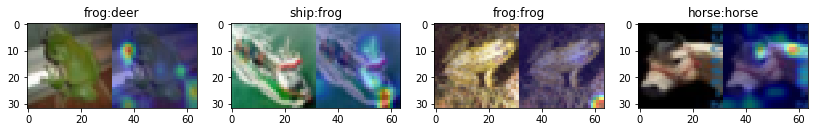

In [0]:
plot_gradCam(model, img_list, "gradcam")

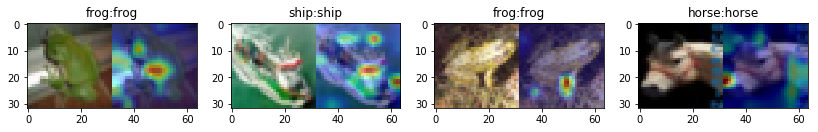

In [0]:
plot_gradCam(cutout_model, img_list, "gradcam_cutout")

### First row is Gradcam without cutout
### Second row Gradcam with cutout
Each image has original and gradcam side by side.

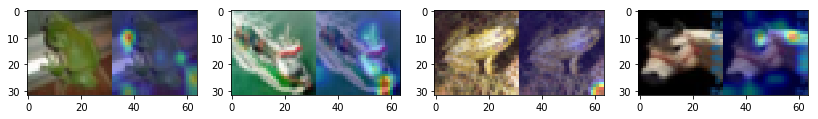

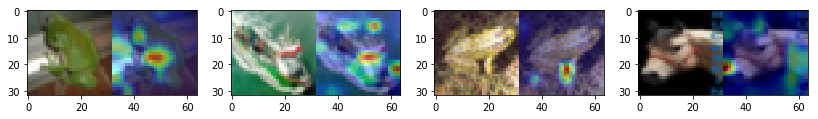

In [0]:
fig = plt.figure(figsize=(14, 4)) # width,height

for i in range(4):
  img_file = dir + "Images/gradcam" + str(i) +".png"
  img = cv2.imread(img_file)
  #print(img.shape, img_file)

  # Plot the concatenanted original and superimposed gradcam images
  sub = fig.add_subplot(1, 4, i+1) # nrows, ncols, index 
  sub.imshow(img)

fig = plt.figure(figsize=(14, 4)) # width,height
for i in range(4):
  img_file = dir + "Images/gradcam_cutout" + str(i) +".png"
  img = cv2.imread(img_file)

  # Plot the concatenanted original and superimposed images on model with cutout
  sub = fig.add_subplot(1, 4, i+1) # nrows, ncols, index 
  sub.imshow(img) 

For the first 2 gradcam images of frog and ship, more areas are in focus with cutout, leading to correct prediction.

Next 2 images, though predicted correctly in both models, in cutout, the frog has part of its legs covered. And for the last image of horse, the nose tip is in focus.

Extension - integrate with cutout, not random patching with average pixel intensity of the entire dataset.